In [84]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.utils import tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

In [85]:
new_df = pd.read_csv('../Updated_Data_2_6_All_Coding.csv')

In [86]:
new_df['extract'] = new_df['extract'].astype(str)
new_df['BINARY_CODE'] = new_df['code'] != 'n'
new_df['BINARY_CODE'] = new_df['BINARY_CODE'].astype(int)
sum(new_df['BINARY_CODE']) / len(new_df)

0.2304994154000334

In [87]:
def numericize_codes(x):
    if x == 'n':
        return 0
    else:
        return int(x)
        
new_df['numeric_code'] = new_df['code'].map(numericize_codes)

In [88]:
def strip_num(x):
    return re.sub('[0-9]', '', x)

def strip_colon(x):
    return re.sub(':', ' ', x)

def strip_youtube(x):
    new_x = re.sub('youtube.com', '', x.lower())
    new_x = re.sub('watch inzvczly', '', new_x.lower())
    new_x = re.sub('youtubehttps', '', new_x.lower())
    new_x = re.sub('youtube', '', new_x.lower())
    new_x = re.sub('bcwzrgivw', '', new_x.lower())
    new_x = re.sub('xnffhyguy', '', new_x.lower())
    new_x = re.sub('com/watch', '', new_x.lower())
    new_x = re.sub('v=iaswsgbq/', '', new_x.lower())
    new_x = re.sub('www', '', new_x)
    new_x = re.sub('https', '', new_x)
    new_x = re.sub('./watch ?', '', new_x)
    new_x = re.sub('//full show', '', new_x)
    new_x = re.sub('v=*/', '', new_x)
    new_x = re.sub('_', ' ', new_x)
    return new_x

def strip_non_ascii(x):
    new_str = []
    for char in x:
        if ord(char) <= 122:
            new_str.append(char)
    return ''.join(new_str)

new_df['extract'] = new_df['extract'].map(strip_num)
new_df['extract'] = new_df['extract'].map(strip_colon)
new_df['extract'] = new_df['extract'].map(strip_youtube)
new_df['extract'] = new_df['extract'].map(strip_non_ascii)

In [89]:
# Create training dataset
train_df, test_df = train_test_split(new_df, test_size=0.1, random_state=47)

In [90]:
count_vect = CountVectorizer(stop_words="english", ngram_range=(1,4), max_features=5000)
X_train_counts = count_vect.fit_transform(train_df['extract'])
X_test_counts = count_vect.transform(test_df['extract'])
print(X_train_counts.shape)
print(X_test_counts.shape)

(10776, 5000)
(1198, 5000)


In [91]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [92]:
nb_clf = MultinomialNB().fit(X_train_tfidf, train_df['BINARY_CODE'])

In [93]:
nb_predicted = nb_clf.predict(X_test_tfidf)
np.mean(nb_predicted == test_df['BINARY_CODE'])

0.8138564273789649

In [94]:
lr_clf = LogisticRegression(solver='lbfgs', penalty='l2').fit(X_train_tfidf, train_df['BINARY_CODE'])

In [95]:
lr_predicted = lr_clf.predict(X_test_tfidf)
lr_predicted_prob = lr_clf.predict_proba(X_test_tfidf)
np.mean(lr_predicted == test_df['BINARY_CODE'])

0.8146911519198664

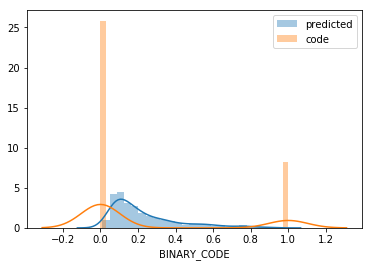

In [96]:
sns.distplot(lr_predicted_prob[:,1], label='predicted');
sns.distplot(test_df['BINARY_CODE'], label="code")
plt.legend();

In [97]:
fpr, tpr, _ = roc_curve(test_df['BINARY_CODE'], lr_predicted_prob[:,1])
roc_auc = auc(fpr, tpr)

fpr_micro, tpr_micro, _ = roc_curve(test_df['BINARY_CODE'].ravel(), lr_predicted_prob[:,1].ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

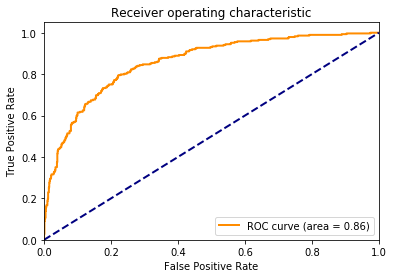

In [98]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [99]:
test_df[test_df['BINARY_CODE']!=lr_predicted].groupby('code').count()['BINARY_CODE']

code
1     1
2    94
3    86
4     2
5     5
6     4
n    30
Name: BINARY_CODE, dtype: int64

In [100]:
for x, y in zip(count_vect.get_feature_names(), list(lr_clf.coef_[0])):
    if y > 1.5:
        print(x)
    if y < -1.5:
        print("**", x)

anti
brutality
bunch
china
christians
cnn
colluded
colluding
collusion
complicit
corporate
corrupt
crimea
** critics
dictator
document
election
fake
fake news
feminist
group
** house
illegal
illegal immigrants
japanese
korean dictator
mainstream
mainstream media
media
north korean dictator
number document
** page
plus
police brutality
** poor
probe
** radio
right wing
russia
russia probe
russian
russian collusion
russians
spies
unqualified
want want
** white house
